In [1]:
import allel
import malariagen_data
import pandas as pd
import numpy as np
%matplotlib inline
import sys
# adding Folder_2 to the system path
sys.path.insert(0, '/home/sanj/projects/gaardian/workflow/scripts/')
import probetools as probe
%run hapclust.py

import statsmodels.api as sm

### Hap association tests - coeae1f

In [2]:
cohorts = [
#     # Ag1000G phase 3 Ghana sample set in Ag3.0
#     "AG1000G-GH",
#     # Amenta-Etego sample sets in Ag3.3
#     #'1190-VO-GH-AMENGA-ETEGO-VMF00013',
#     #'1190-VO-GH-AMENGA-ETEGO-VMF00014',
#     #'1190-VO-GH-AMENGA-ETEGO-VMF00028',
#     #'1190-VO-GH-AMENGA-ETEGO-VMF00029',
#     #'1190-VO-GH-AMENGA-ETEGO-VMF00046',
#     #'1190-VO-GH-AMENGA-ETEGO-VMF00047',
#     # GAARDIAN sample set in Ag3.4
#     #'1244-VO-GH-YAWSON-VMF00149',
#     'AG1000G-ML-A',
#     'AG1000G-BF-A',
#     'AG1000G-BF-B',
#     'AG1000G-GN-A',
#     'AG1000G-GN-B',
    # GAARD Ghana sample set in Ag3.2
    "1244-VO-GH-YAWSON-VMF00051",
    '1245-VO-CI-CONSTANT-VMF00054',
    '1253-VO-TG-DJOGBENOU-VMF00052',
    '1237-VO-BJ-DJOGBENOU-VMF00050'
]

In [3]:
contig= '2L'

coeae1f_start = 28_545_396
coeae1f_end = 28_547_938
coeae2f_start = 28_548_433
coeae2f_end = 28_550_748

coeregion = '2L:28540000-28560000'

transcript= "AGAP006227-RA"
gene = transcript.replace("-RA", "")

In [4]:
ag3 = malariagen_data.Ag3(pre=True)

In [42]:
def gaard_cluster_to_df(cohorts, transcript, contig, name, cut=1, min_cohort_size=40):
    snpdf_227, coho, leav = phase3cluster(cohorts, transcript, contig, cut=cut, t=0, min_cohort_size=min_cohort_size)
    
    metadata = pd.read_csv("/home/sanj/projects/gaard/config/gaard_metadata.tsv", sep="\t", index_col=0)
    haps = ag3.haplotypes(region=coeregion, sample_sets=cohorts, analysis='gamb_colu')
    names = haps['sample_id'].compute().values
    metahaps = load_metahaps(cohorts, names, metaquery=None)

    phenos = pd.read_csv("/home/sanj/projects/gaard/config/gaard_metadata.tsv", sep="\t", index_col=0)[['sample_id', 'partner_sample_id', 'insecticide', 'phenotype']]
    metahaps = metahaps.merge(phenos)
    
    df = metahaps.copy()
    df = df[['sample_id', 'country', 'location', 'phenotype', 'insecticide']]

    for k,v in coho.items():
        k = name + "_" + k
        vals = np.zeros(df.shape[0]).astype(int)
        vals[v] = 1
        df.loc[:, k] = vals

    df = df.groupby(['sample_id', 'country', 'location', 'phenotype', 'insecticide']).agg('sum').reset_index()
    return(df, metahaps)

['1244-VO-GH-YAWSON-VMF00051', '1245-VO-CI-CONSTANT-VMF00054', '1253-VO-TG-DJOGBENOU-VMF00052', '1237-VO-BJ-DJOGBENOU-VMF00050'], query=None, cohort_size : 973
Remapping haplotype alleles to match snp effect data...
Clustering genotypes


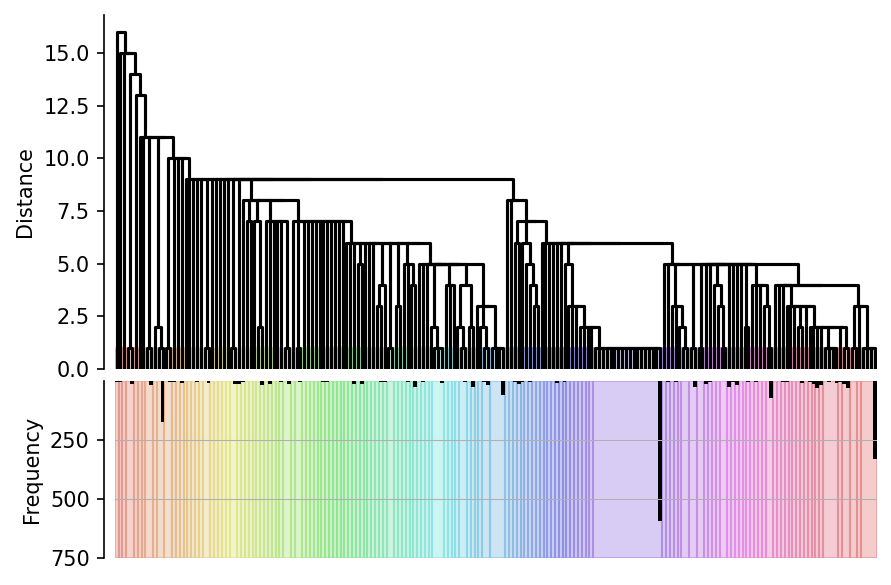

Finding allele frequencies from cluster indices
There are 6 clusters with [173, 63, 612, 75, 336, 687]
['1244-VO-GH-YAWSON-VMF00051', '1245-VO-CI-CONSTANT-VMF00054', '1253-VO-TG-DJOGBENOU-VMF00052', '1237-VO-BJ-DJOGBENOU-VMF00050'], query=None, cohort_size : 973
Remapping haplotype alleles to match snp effect data...
Clustering genotypes


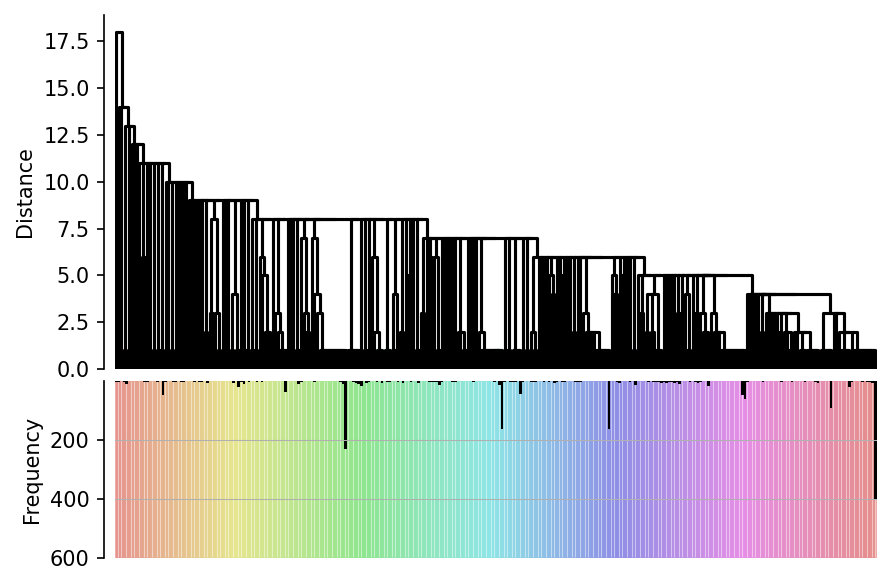

Finding allele frequencies from cluster indices
There are 6 clusters with [231, 163, 164, 91, 403, 834]


In [44]:
clusters_227, metahaps = gaard_cluster_to_df(cohorts, "AGAP006227-RA", "2L", cut=1, name='coeae1f', min_cohort_size=60)
clusters_keap1, metahaps = gaard_cluster_to_df(cohorts, "AGAP003645-RA", "2R", cut=1, name='keap1', min_cohort_size=60)

In [53]:
df = clusters_227.merge(clusters_keap1)

In [50]:
df = clusters_keap1

['1244-VO-GH-YAWSON-VMF00051', '1245-VO-CI-CONSTANT-VMF00054', '1253-VO-TG-DJOGBENOU-VMF00052', '1237-VO-BJ-DJOGBENOU-VMF00050'], query=None, cohort_size : 973
Remapping haplotype alleles to match snp effect data...
Clustering genotypes


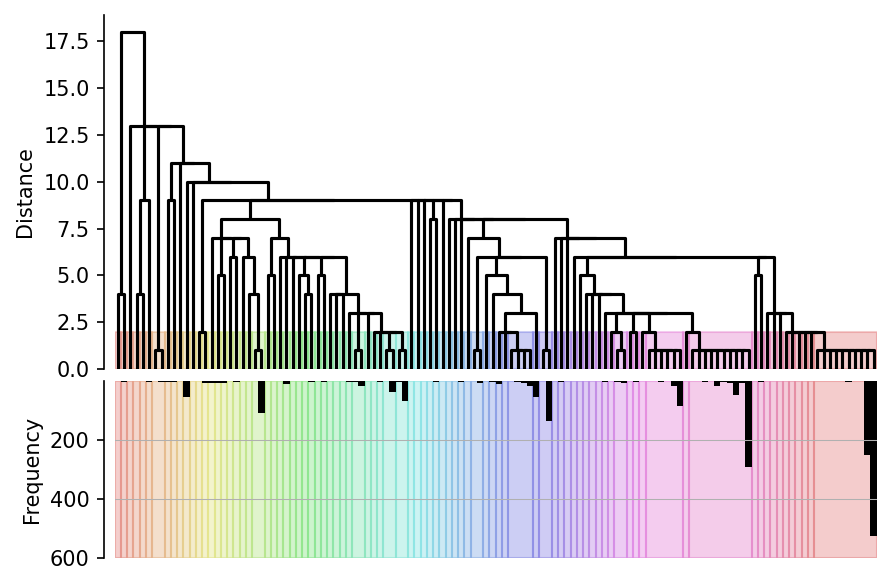

Finding allele frequencies from cluster indices
There are 7 clusters with [111, 70, 137, 107, 380, 787, 354]


In [68]:
clusters_6aa, metahaps = gaard_cluster_to_df(cohorts, "AGAP002862-RA", "X", cut=2, name='cyp6aa1', min_cohort_size=60)

In [51]:
'phenotype ~ COUTAX + UNEMPF + COUTAX:UNEMPF + MOR'

'YES ~ COUTAX + UNEMPF + COUTAX:UNEMPF + MOR'

In [72]:
df = clusters_6aa

In [73]:
for ins in ['PM', 'Delta']:
    df2 = df.query("insecticide == @ins")   
    clusters = df2.iloc[:, 5:].astype(float)
    phenos = pd.factorize(df2['phenotype'])[0]
    
    # Instantiate a gamma family model with the default link function.
    logit_model = sm.GLM(phenos, clusters, family=sm.families.Binomial())
    logit_results = logit_model.fit()

    print(ins, logit_results.summary())
    print(np.exp(logit_results.params),"\n")
    params = logit_results.params
    conf = logit_results.conf_int()
    conf['Odds Ratio'] = params
    conf.columns = ['5%', '95%', 'Odds Ratio']
    print(np.exp(conf), "\n")

PM                  Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  422
Model:                            GLM   Df Residuals:                      415
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -283.59
Date:                Tue, 16 Aug 2022   Deviance:                       567.18
Time:                        15:07:07   Pearson chi2:                     422.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.02431
Covariance Type:            nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [74]:
for ins in ['PM', 'Delta']:
    df2 = df.query("insecticide == @ins")   
    phenos = pd.factorize(df2['phenotype'])[0]

    for k,v in coho.items():
        clusters = df2.loc[:, k].astype(float)
        df3 = df2[df2.loc[:, k] > 0]
        
        # Instantiate a binom family model with the default link function.
        logit_model = sm.GLM(phenos, clusters, family=sm.families.Binomial())
        logit_results = logit_model.fit()

        print(k, ins, logit_results.summary())
        print(df3['aim_species'].value_counts(), "\n\n\n\n")

KeyError: 'n=173 | E477V'

In [5]:
def plot_snps(transcript, data, cohorts, width=1500, height=600, palette='Category10', sample_set="sample_set"):

    # hover tooltips
    tooltips = [
        ("position", '@contig:@position{,}'),
        ("alleles", '@ref_allele>@alt_allele'),
        ("pass", "@pass_gamb_colu_arab, @pass_gamb_colu, @pass_arab"),
        ("impact", '@impact'),
        ("effect", '@effect'),
        ("aa_change", '@aa_change'),
        ("frequency", '@frequency{%f} (@cohort)'),
        ("freqdiff from wildtype", '@freq_diff_from_wt{%f}'),
    ]

    fig1 = bokeh.plotting.figure(
        title=f'Transcript - {transcript}',
        tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,reset,hover',
        active_scroll='xwheel_zoom',
        active_drag='xpan',
        plot_width=width, 
        plot_height=height, 
        tooltips=tooltips,
        toolbar_location="above")

    # set up colors
    palette = bokeh.palettes.all_palettes[palette]
    colors = palette[len(cohorts)] if len(cohorts) > 2 else palette[3]
    
    # plot allele frequencies
    for coh, color in zip(cohorts, colors):
        df = data.copy()
        # add X coordinate in Mbp
        df['x'] = df['position'] / 1e6
        df['frequency'] = df[coh]
        df['cohort'] = coh
        df['freq_diff_from_wt'] = data[f"{coh} | freqdiff"] if "wt" not in coh else 0 
        diffdf = df.query("freq_diff_from_wt > 0.4")
        df = df.query("freq_diff_from_wt < 0.4")
        fig1.triangle("x", coh, 
                      size=8, 
                      color=color,
                      source=df,
                      legend_label=coh)
        fig1.circle("x", coh, 
                    size=10, color=color, 
                    source=diffdf,
                    legend_label=coh)

    # tidy up the plot
    fig1.y_range = bokeh.models.Range1d(-0.05, 1.1)
    fig1.yaxis.axis_label = f'Alt allele frequency'
    fig1.xaxis.visible = False
    fig1.add_layout(fig1.legend[0], 'right')
    fig1.legend.click_policy="hide"

    # plot transcript
    fig2 = plot_transcript(transcript, width=width, height=80, show=False, 
                           x_range=fig1.x_range)
    fig2.toolbar.logo = None 
    fig2.toolbar_location = None
    fig2.title = None #sample_set

    bokeh.plotting.show(bokeh.layouts.column(fig1, fig2))
    
def plot_transcript(transcript, width=700, height=120, show=True, x_range=None,
                    toolbar_location='above'):

    # find the gene
    df_geneset = ag3.geneset().set_index("ID")
    parent  = df_geneset.loc[transcript]

    # define tooltips for hover
    tooltips = [
        ("Type", '@type'),
        ("Location", '@contig:@start{,}..@end{,}'),
    ]

    # make a figure
    fig = bokeh.plotting.figure(
        title=f'Transcript - {transcript} ({parent.strand})',
        plot_width=width, 
        plot_height=height,
        tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,reset,hover',
        toolbar_location=toolbar_location,
        active_scroll='xwheel_zoom',
        active_drag='xpan',
        tooltips=tooltips,
        x_range=x_range,
    )

    # find child components of the transcript
    data = df_geneset.query(f"Parent == '{transcript}'").copy()
    data['left'] = data['start'] / 1e6  # plot in Mbp coordinates
    data['right'] = data['end'] / 1e6  # plot in Mbp coordinates
    data['bottom'] = -0.4
    data['top'] = 0.4

    # plot exons
    exons = data.query("type == 'exon'")
    fig.quad(bottom='bottom', top='top', left='left', right='right',
             source=exons, fill_color=None, line_color='black', line_width=.5, 
             fill_alpha=0)
    
    # plot introns
    for l, r in zip(exons[:-1]['right'], exons[1:]['left']):
        m = (l + r) / 2
        fig.line([l, m, r], [0, .1, 0], line_width=1, line_color="black")

    # plot UTRs
    fig.quad(bottom='bottom', top='top', left='left', right='right',
                source=data.query("type == 'five_prime_UTR'"), 
                fill_color='green', line_width=0, fill_alpha=.5)
    fig.quad(bottom='bottom', top='top', left='left', right='right',
                source=data.query("type == 'three_prime_UTR'"), 
                fill_color='red', line_width=0, fill_alpha=.5)

    # plot CDSs
    fig.quad(bottom='bottom', top='top', left='left', right='right',
             source=data.query("type == 'CDS'"), 
             fill_color='blue', line_width=0, fill_alpha=.5)

    fig.yaxis.ticker = []
    fig.xaxis.axis_label = f'Position (Mbp)'
    fig.y_range = bokeh.models.Range1d(-.6, .6)

    fig.xaxis.axis_label = f'Contig {parent.contig} position (Mbp)'

    # show the figure
    if show:
        bokeh.plotting.show(fig)

    return fig

def clustersToFrequencies(transcript, cluster_spans, geno, pos, SNPeffect='NON_SYNONYMOUS_CODING', max_af=0.02, min_cohort_size=5, sample_set="sample_set"):
    
    # get totals in each sweep for swept and wt, store in dict
    cohorts = {f"Sweep n={c[2].shape[0]}":c[2] for idx, c in enumerate(cluster_spans) if c[2].shape[0] > min_cohort_size}
    wt = {f"wt_{idx}":c[2] for idx, c in enumerate(cluster_spans) if c[2].shape[0] < min_cohort_size}
    lenwt = len(np.concatenate(list(wt.values())))
    cohorts[f'wt n={lenwt}'] = np.concatenate(list(wt.values()))
    
    probe.log(f"There are {len(cohorts.keys())} clusters with {[len(c) for c in cohorts.values()]}")
    
    #calculate allele freqs in cohort 
    df_snps = get_afs_from_cohort(cohorts, geno, pos, transcript, min_cohort_size)
    # filter to snp eff and max af
    df_snps_filtered = df_snps.query("effect == @SNPeffect and max_af > @max_af")
    
    #change cohort dict keys to amino acid signature (what is diff from wt?)
    newcohort, df_snps_filtered = get_aasig_for_swept_cohorts(cohorts, df_snps_filtered)
    
    #plot allele frequencies for each cohort 
    #plot_snps(transcript, data=df_snps_filtered, cohorts=newcohort, sample_set=sample_set)
    
    return(df_snps_filtered, newcohort)

def TranscriptSweptAlleleFreqs(snps, pos, transcript, cut_height = 120, t=2, min_cohort_size=5, sample_set="sample_set", dendro_only=False, metaquery=None):
    
    probe.log("Remapping haplotype alleles to match snp effect data...")   
    haplos = allel.GenotypeArray(snps['call_genotype']).to_haplotypes()
    haplos, pos = remap_haplo_alleles(haplos=haplos, haplo_pos=pos, transcript=transcript, metaquery=metaquery)
        
    probe.log("Clustering genotypes")
    fig, ax_dend, ax_freq, cluster_spans, leaves = fig_haplotypes_clustered(haplos, 
                                                              truncate_distance=t,
                                                              cut_height=cut_height,
                                                              dpi=150, label_clusters=False)
    plt.show()
    
    probe.log("Finding allele frequencies from cluster indices")
    # Take clusters and get freqs in each cluster
    df_snps_filtered, newcohort = clustersToFrequencies(transcript, cluster_spans, geno=haplos, pos=pos, min_cohort_size=min_cohort_size, sample_set=sample_set)

    return(df_snps_filtered, newcohort, leaves)
    
    
def phase3cluster(sample_set, transcript, contig, metaquery=None, cut=2, t=2, min_cohort_size=5):
    snps = ag3.haplotypes(transcript, sample_sets=sample_set, analysis='gamb_colu')
    meta = ag3.sample_metadata(sample_set)

    if metaquery != None:
        meta = ag3.sample_metadata(cohorts)
        meta = meta.query(metaquery)
        sample_bool = np.isin(snps['sample_id'].compute(), meta['sample_id'])
        snps = snps.isel(samples=sample_bool)

    probe.log(f"{sample_set}, query={metaquery}, cohort_size : {snps['call_genotype'].shape[1]}")

    df_af, coh, leaves = TranscriptSweptAlleleFreqs(snps, allel.SortedIndex(snps['variant_position']), transcript, cut_height=cut, t=t, min_cohort_size=min_cohort_size, sample_set=sample_set, metaquery=metaquery)  
    return(df_af, coh, leaves)

def get_afs_from_cohort(cohorts, geno, pos, transcript, min_cohort_size):
    freq_cols = dict()
    for coh, loc_coh in cohorts.items():
        n_samples = np.count_nonzero(loc_coh)
        if n_samples == 0:
            raise ValueError(f"no samples for cohort {coh!r}")
        if n_samples >= min_cohort_size:
            gt_coh = geno.take(loc_coh, axis=1)
            # count alleles
            ac_coh = gt_coh.count_alleles(max_allele=3)
            # compute allele frequencies
            af_coh = ac_coh.to_frequencies()
            # add column to dict
            freq_cols[coh] = af_coh[:, 1:].flatten()

    # build a dataframe with the frequency columns
    df_freqs = pd.DataFrame(freq_cols)

    # compute effects for all SNPs in chosen transcript
    df_effects = ag3.snp_effects(
        transcript=transcript, 
    )
    
    pos_bool = np.isin(df_effects['position'], pos)
    df_effects = df_effects[pos_bool]
    
    # build the final dataframe
    df_effects.reset_index(drop=True, inplace=True)
    df_snps = pd.concat([df_effects, df_freqs], axis=1)

    # add max allele freq column (concat here also reduces fragmentation)
    df_snps = pd.concat(
        [
            df_snps,
            pd.DataFrame(
                {"max_af": df_snps[list(freq_cols.keys())].max(axis=1)}
            ),
        ],
        axis=1,
    )
    return(df_snps)


def get_aasig_for_swept_cohorts(cohorts, df_snps_filtered):
    newcohort = {}
    for key, idxs in cohorts.items():
        # copy df
        df = df_snps_filtered.copy()
        # calculate AF diff between wt and each sweep
        df['af_diff']= df[key] - df.filter(regex="wt").iloc[:,0]
        # difference has to be greater than 0.4 (arbitrary)
        aadiff = df[df['af_diff'] > 0.4]['aa_change'] #.abs() used if we want aa reversion to show on signature
        # remove first digits
        aa = aadiff.str.slice(1)
        aa = ",".join(aadiff)
        n = int(''.join(filter(str.isdigit, key)))
        aa = f"n={n} | {aa}"
        if "wt" not in key:
            newcohort[aa] = idxs
            df_snps_filtered = df_snps_filtered.rename(columns={key:aa})
            df_snps_filtered[f"{aa} | freqdiff"] = (df_snps_filtered.filter(regex="wt").iloc[:,0] - df_snps_filtered[aa]).abs()
        else:
            newcohort[key] = idxs
        
    return(newcohort, df_snps_filtered)

def remap_haplo_alleles(haplos, haplo_pos, transcript, metaquery):
    """
    Because haplotypes are coded 0,1, but genotypes 0-3, 1s in the haplotype may refer to different ALTs in the genotype array. This
    causes a problem when using ag3.snp_effects() to fit alleles to their aa change, therefore, we need to recode alleles back to the correct
    ALT
    """
    # Load genotype data - needed to find correct ALT for each SNP
    geno = allel.GenotypeDaskArray(ag3.snp_genotypes(region=transcript, sample_sets=cohorts))
    meta = ag3.sample_metadata(cohorts)
    if metaquery != None:
        meta = meta.query(metaquery)
    geno = geno.take(meta.index.to_list(), axis=1)
    geno_pos = allel.SortedIndex(ag3.snp_sites(region=transcript, field='POS').compute())
    
    # find intersection between haplotype positions and genotypes 
    geno_mask, hap_mask = geno_pos.locate_intersection(haplo_pos)
    geno = geno.compress(geno_mask, axis=0)
    ac = geno.count_alleles().compute()
    
    # remove multiallelics, there shouldnt be any in here?
    multiallele_mask = (ac > 0).sum(axis=1) > 2
    ac = ac[~multiallele_mask]
    # find appropriate allele
    mappings = np.argmax(ac[:,1:], axis=1) + 1
    # make mapping array for scikit-allel
    zeros = np.zeros(len(mappings))
    mapping = np.vstack([zeros, mappings]).T
    
    # Remap!
    haplos = haplos[~multiallele_mask].map_alleles(mapping)
    haplo_pos  = haplo_pos[~multiallele_mask]
       
    return(haplos, haplo_pos)

def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

def load_metahaps(cohorts, names, metaquery = "aim_species == 'gambiae'"):
    meta = ag3.sample_metadata(cohorts)
    meta = meta.query("sample_id in @names")
    meta.loc[:, 'sample_id'] = pd.Categorical(meta['sample_id'], categories = names, ordered = True)
    if metaquery != None: 
        query_bool = meta.eval(metaquery)
        meta = meta.query(metaquery)
    meta = meta.sort_values(by='sample_id')
    metahaps = pd.DataFrame(np.repeat(meta.values, 2, axis=0))
    metahaps.columns = meta.columns
    if metaquery == None:
        return(metahaps)
    else:
        return(metahaps, query_bool)

def check_order(meta, order, col='sample_id'):
    assert meta[col].to_list() == order, "Order of metadata is incorrect"
    print("correct order")
    
def haplotypes_to_aa_pandas(haps_xarray, snpdf, myquery="max_af > 0.05 & effect == 'NON_SYNONYMOUS_CODING'", reverse=False, metaquery= "aim_species == 'gambiae'"):
    #Subset the data to all aa changes above 5% frequency
    aa_snps = snpdf.query(myquery)['position'].to_list()
    pos_bool = allel.SortedIndex(haps_xarray['variant_position'].values).locate_intersection(aa_snps)[0]
    print(f"There are {len(aa_snps)} amino acid changes with {myquery}")
    
    metahaps, query_bool = load_metahaps(cohorts, names, metaquery=metaquery)
    haps2 = allel.GenotypeArray(haps_xarray['call_genotype'].isel(variants=pos_bool, samples=query_bool).compute()).to_haplotypes()
    
    haps_df = pd.DataFrame(haps2)
    haps_df.loc[:, 'aa_change'] = snpdf.query(myquery).reset_index()['aa_change']
    haps_df = haps_df.set_index('aa_change')
    haps_df = haps_df.iloc[::-1] if reverse == True else haps_df # only if reverse strand like AGAP006227
    return(haps_df) # can only run once!